## Import Libraries

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import os
from dataclasses import dataclass

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F



In [2]:
np.random.seed(0)
torch.manual_seed(0);

In [3]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 16
    epochs_count: int = 1
    init_learning_rate: float = 0.003  # initial learning rate for lr scheduler
    log_interval: int = 5
    test_interval: int = 1
    data_root: str = "C:\\Users\\Thunder\\PycharmProjects\\model_training_cvdl\\data\cat-dog-panda\\"
    num_workers: int = 2
    device: str = 'cuda'
    dropout = 0.2


# Study data

How to study data for a classification problem
1. read the data


In [4]:
import os
import glob
root_data_path = 'data/cat-dog-panda/'

def data_info(root_data_path):
    dataset = glob.glob(root_data_path+'/*')
    for dst in dataset:
        print(f"\n{os.path.basename(dst)} path: '{dst}'")
        classes = os.listdir(dst)
        print(f'classes in {os.path.basename(dst)}: {classes}\n')
        # Get Class count per dataset
        for cls in classes:
            print(f'{cls}: {len(glob.glob(os.path.join(f"{dst}/{cls}/*")))}')
    return

data_info(root_data_path)


training path: 'data/cat-dog-panda\training'
classes in training: ['cat', 'dog', 'panda']

cat: 800
dog: 800
panda: 800

validation path: 'data/cat-dog-panda\validation'
classes in validation: ['cat', 'dog', 'panda']

cat: 200
dog: 200
panda: 200


In [5]:
def image_transformer(mean,std):
    transformer = transforms.Compose([
                        transforms.Resize((224, 224)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean,std)
                    ])
    return transformer

def common_image_transformer():    
    transformer = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
    return transformer

In [6]:
#define data loader
def data_loader(train_path, transformer, batch_size=16, shuffle=False, num_workers=2):
    
    train_data = datasets.ImageFolder(train_path, transform=transformer)
    loader = torch.utils.data.DataLoader(train_data,
                                         batch_size=batch_size,
                                         num_workers=num_workers,
                                         shuffle=shuffle)
    return loader

# https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/
def get_mean_std(data_root, num_workers=4):

    transform = common_image_transformer()

    loader = data_loader(data_root, transform)

    batch_mean = torch.zeros(3)
    batch_mean_sqrd = torch.zeros(3)

    for batch_data, _ in loader:
        batch_mean += batch_data.mean(dim=(0, 2, 3)) # E[batch_i]
        batch_mean_sqrd += (batch_data ** 2).mean(dim=(0, 2, 3)) #  E[batch_i**2]

    mean = batch_mean / len(loader)

    var = (batch_mean_sqrd / len(loader)) - (mean ** 2)

    std = var ** 0.5
    # print('mean: {}, std: {}'.format(mean, std))

    return mean, std


def get_data(batch_size, data_root, num_workers=4,):
    
  
    mean, std = get_mean_std(data_root)
    train_transform = image_transformer(mean=mean, std=std)
    

    train_loader = data_loader(data_root, train_transform, batch_size= batch_size, shuffle= True ,num_workers=num_workers)
    test_loader = data_loader(data_root, train_transform, batch_size= batch_size, shuffle= False ,num_workers=num_workers)

    return train_loader, test_loader

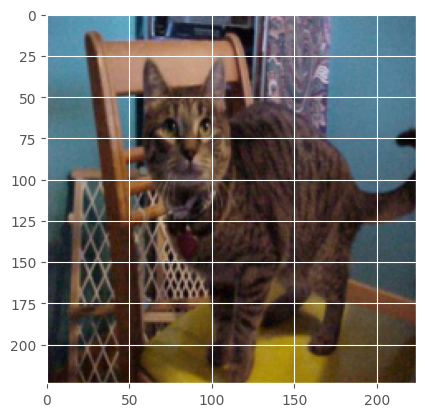

In [7]:
# test train dataloader
train_path = os.path.join(root_data_path,"training")
validation_path = os.path.join(root_data_path,"validation")

train_transform = common_image_transformer()

train_dataloader = data_loader(train_path, transformer= train_transform)
images , labels = next(iter(train_dataloader))

# Use transpose instead of reshape.
img = images[0].numpy().transpose((1, 2, 0))
plt.imshow(img);
# plt.title(f'{labels[0]}')
# train_dataloader.show_batc

In [8]:
#Get per class data distrinution in each dataset

In [9]:
# print(train_data.class_to_idx.items())

# Perform Feature Engineering

# Model Training

In [10]:
# define model
class MyModel(nn.Module):
  def __init__(self, dropout=0.0):
      super().__init__()

      # Body (Feature Extractor)
      self.body = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2,stride=2),


        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2,stride=2),


        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2,stride=2),


        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2,stride=2),


        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2,stride=2),
        nn.Dropout(dropout)
        )
      


      # Head (Classifier)
      self.head = nn.Sequential(

          nn.Linear(in_features=512 * 7 * 7, out_features=4096),
          nn.ReLU(inplace=True),
          nn.Dropout(dropout),

          nn.Linear(in_features=4096, out_features=1000),
          nn.ReLU(inplace=True),
          nn.Dropout(dropout),

          nn.Linear(in_features=1000, out_features=3)
      )

  def forward(self, x):
      x = self.body(x)
      x = x.view(x.size()[0], -1)
      x = self.head(x)
      return x


In [11]:
# define training loop
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> None:
    print("Training started!")
    total_epochs = train_config.epochs_count
    
    # change model in training mood
    model.train()

    # To get batch loss
    train_total_loss =  0.0

    # To get batch accuracy
    train_total_samples =0.0
    correct_per_batch = 0.0
    train_total_acc =  0.0
    
# for epoch in total_epoch:
    for batch_idx, (images, targets) in enumerate(train_loader):

        indx_target = targets.clone()
        # send data to device (its is medatory if GPU has to be used)
        images = images.to(train_config.device)
        # send target to device
        targets = targets.to(train_config.device)

        # forward pass to the model
        output = model(images)
        # cross entropy loss
        loss_per_batch = F.cross_entropy(output, targets)

        train_total_loss += loss_per_batch.item()
        
        # reset parameters gradient to zero
        optimizer.zero_grad()
        # find gradients w.r.t training parameters
        loss_per_batch.backward()
        # Update parameters using gardients
        optimizer.step()

        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
        # get the index of the max probability
        pred = torch.argmax(prob.data, dim=1)

        # correct prediction
        correct_per_batch += sum(pred.cpu() == indx_target).item()
        train_total_acc += correct_per_batch/len(images)
        train_total_samples += len(indx_target) 
    
    train_loss_per_epoch = train_total_loss/len(train_dataloader)
    train_acc_per_epoch = train_total_acc/train_total_samples


    print(f'Epoch: {epoch_idx}/{total_epochs} \nTrain Loss: {train_loss_per_epoch:.6f} Acc: {train_acc_per_epoch:.4f}')
    return train_loss_per_epoch, train_acc_per_epoch

In [12]:
# # #testing test loop
# train_config = TrainingConfiguration()

# train_loader, test_loader = get_data(batch_size = train_config.batch_size,data_root=train_config.data_root)
# model = MyModel(dropout = train_config.dropout)
# model.to(train_config.device)
# optimizer = optim.Adam(model.parameters(),
#                       lr = train_config.init_learning_rate)

# # Training 
# train(train_config= train_config, model=model,optimizer= optimizer, train_loader=train_loader,epoch_idx=0) 

In [13]:
# define validation loop
def validate(
    train_config: TrainingConfiguration, model: nn.Module,
    test_loader: torch.utils.data.DataLoader
) -> float:    
    # change model in testing mood
    model.eval()

    # To get batch loss
    val_total_loss = 0

    # To get batch accuracy
    val_total_samples = 0
    correct_per_batch = 0
    val_total_acc = 0

    for images, targets in test_loader:

        indx_target = targets.clone()
        # send data to device (its is medatory if GPU has to be used)
        images = images.to(train_config.device)
        # send target to device
        targets = targets.to(train_config.device)

        with torch.no_grad():
            # forward pass to the model
            output = model(images)

        # cross entropy loss
        val_loss = F.cross_entropy(output, targets).item()
        val_total_loss += val_loss

        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
        # get index of max probability
        pred = torch.argmax(prob.data, dim=1)
        
        # correct prediction
        correct_per_batch += sum(pred.cpu() == indx_target).item()
        val_total_acc += correct_per_batch/len(images)
        val_total_samples += len(images)
    
    val_loss_per_epoch = val_total_loss / len(test_loader)

    val_acc_per_epoch = val_total_acc / val_total_samples
        
    print(f'\n val_Loss: {val_loss_per_epoch:.6f} val_Acc: {val_acc_per_epoch:.4f}')
    return val_loss_per_epoch, val_acc_per_epoch

## <font style="color:blue">4.4. Save the Model</font>

In [14]:
# using datetime module

print(os.path.join('model_dir', 'model_file_name','ct'))

model_dir\model_file_name\ct


In [15]:
### Add option to save model with training config 

# import datetime
# ct = datetime.datetime.now().strftime("%HH%MM%SS")

def save_model(model, device, model_dir='models', model_file_name='cat_dog_panda_classifier.pt'):

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # make sure you transfer the model to cpu.
    if device == 'cuda':
        model.to('cpu')

    # save the state_dict
    torch.save(model.state_dict(), model_path)

    if device == 'cuda':
        model.to('cuda')

    return

## <font style="color:blue">4.5. Load the Model</font>

In [16]:
def load_model(model, model_dir='models', model_file_name='cat_dog_panda_classifier.pt'):
    model_path = os.path.join(model_dir, model_file_name)

    # loading the model and getting model parameters by using load_state_dict
    model.load_state_dict(torch.load(model_path))

    return model

# Main Function for Training

In [17]:
def main(model, optimizer, scheduler=None,train_config=TrainingConfiguration()):

  
    # batch size
    batch_size_to_set = train_config.batch_size
    # num_workers
    num_workers_to_set = train_config.num_workers
    # epochs
    epoch_num_to_set = train_config.epochs_count

    # if GPU is available use training config,
    # else lowers batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 4

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=train_config.data_root,
        num_workers=num_workers_to_set
    )

    # Update training configuration
    train_config = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )

    # send model to device (GPU/CPU)
    model.to(train_config.device)

    best_loss = torch.tensor(np.inf)

    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])

    # epch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])

    # Calculate Initial Test Loss
    init_val_loss, init_val_accuracy = validate(train_config, model, test_loader)
    print("Initial Test Loss : {:.6f}, \nInitial Test Accuracy : {:.3f}%\n".format(init_val_loss,
                                                                                   init_val_accuracy*100))

    # trainig time measurement
    t_begin = time.time()
    for epoch in range(train_config.epochs_count):

        # Train
        train_loss, train_acc = train(train_config, model, optimizer, train_loader, epoch)

        epoch_train_loss = np.append(epoch_train_loss, [train_loss])

        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * train_config.epochs_count - elapsed_time

        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        # Validate
        if epoch % train_config.test_interval == 0:
            current_loss, current_accuracy = validate(train_config, model, test_loader)

            epoch_test_loss = np.append(epoch_test_loss, [current_loss])

            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])

            if current_loss < best_loss:
                best_loss = current_loss
                print('Model Improved. Saving the Model...\n')
                save_model(model, device=train_config.device)



    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))

    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

In [18]:
train_config = TrainingConfiguration()

model = MyModel(dropout = train_config.dropout)

optimizer = optim.Adam(model.parameters(),
                      lr = train_config.init_learning_rate)

# Training 
main(model=model,optimizer= optimizer,scheduler=None, train_config= train_config) 


 val_Loss: 1.098127 val_Acc: 0.2593
Initial Test Loss : 1.098127, 
Initial Test Accuracy : 25.933%



NameError: name 'time' is not defined

In [ ]:
# make a loss function take allow you to change the loss function in training loop just like in keras using model.compiler
# def loss(loss_function = ,output,target):
    # if loss_function:


# Evaluate Model Performance

# Record Experimentation Results

#set up random seed at the start of model training
np.random.seed(0)
torch.manual_seed(0)


# Perform Model Ensembling